# Week 8 聚类和PCA
- k-means方法的目的是最小化函数J:
$$J(c^{(1)}, ..., c^{(m)}, \mu_1, ..., \mu_k)=\frac{1}{m}\sum^m_{i=1}||x^{(i)}-\mu_{c^{(i)}}||^2$$
- k-means的过程:  
  1. 随机初始化(在集合中随机选择K个点作为聚类中心)
  2. Repeat直到收敛:  
      1. 对集合中m个点求其离各个聚类中心的距离, 选择最短的距离并填写$c^{(i)}$为其属于哪一类  (其实这一步做的是参数$\mu_i$不变, 求使J最小的$c^{(i)}$)
      2. 将每类点求取平均向量, 得到k个新的聚类中心 (其实这步是参数$c^{(i)}$不变, 求使J最小的$\mu_i$)
- k-means求得的是局部最小值, 为了解决这个问题, 可以多次随机初始化进行k-means, 然后选择其最终J最小的一组
- 选择k值  可以画出k和J的图, 找出最优点; 也可以根据实际意义来选择
- PCA是一种降维的方法, PCA不是线性回归, PCA的误差是初始的数据点到低维空间投影点的距离.
- PCA过程(将n维降到k维):
  1. 数据预处理(归一化)
  2. 使用PCA算法
     1. $\Sigma=\frac{1}{m}\sum^n_{i=1}(x^{(i)})(x^{(i)})^T$  (得到一个n * n的矩阵)
     2. $[U, S, V] = svd(\Sigma)$ (U为n * n矩阵, 取前k列为Ureduce(映射到的低维空间). 即Ureduce = U(:,:k) )
     3. 求最后的k维数据为:　$z = Ureduce^T * x$
- PCA的损失(误差)为: 先将x从n维降到k维度得到z, 再z从k维升到n维得到$x_{approx}$ $x_{approx}=Ureduce * z$  
  误差为$\frac{1}{m}\sum^m_{i=1}||x^{(i)}-x_{approx}^{(i)}||^2$  
  总的variation为$\frac{1}{m}\sum^m_{i=1}||x^{(i)}||^2$  
  所以损失的信息为$\frac{\frac{1}{m}\sum^m_{i=1}||x^{(i)}-x_{approx}^{(i)}||^2}{\frac{1}{m}\sum^m_{i=1}||x^{(i)}||^2}$
- 选择PCA的k值: 利用svd(奇异值分解)返回的S矩阵(为对角矩阵)
  $\frac{\sum_{i=1}^kS_{ii}}{\sum_{i=1}^mS_{ii}}$为将n维转换为k维留下的信息比例. 所以若要损失信息少于百分之一, 只需该式大于0.99
- PCA不能防止过拟合
- 不要一开始就想着PCA, 先用原始值进行训练, 若效果不好(如速度过慢, 占用空间过大)再使用PCA降维, 用映射值训练
  

In [44]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as sio
import math
import scipy.optimize as op

data2 = sio.loadmat('data/ex7data2.mat')
X2 = data2['X']

In [16]:
# Part 1: Find Closest Centoids
def find_closest_centroids(X, centroids):
    m, n = X2.shape
    def help(x, centroids):
        #x (n,) centroids(k,n)
        return ((x-centroids)**2).sum(axis=1)
    return np.apply_along_axis(help, 1, X, centroids).argmin(axis=1)
    

K = 3
initial_centroids = np.array([[3, 3], [6, 2], [8,5]])

init_idx = find_closest_centroids(X2, initial_centroids)
print(init_idx[:3]) # 输出0, 2, 1

[0 2 1]


In [17]:
# Part 2: Compute Means
def compute_centroids(X, idx, k):
    res = np.zeros((k, X.shape[1]))
    for i in range(k):
        res[i] = X[idx==i, :].mean(axis=0)
    return res
print(compute_centroids(X2, init_idx, 3))

[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


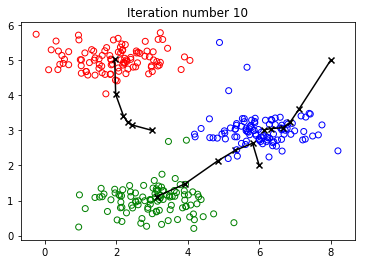

In [76]:
# Part 3: K-Means Clustering
def run_kmeans(X, centroids, max_iters, isplot, colors=None):
    k, n = centroids.shape
    record = np.zeros((max_iters, k, n))
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        temp_centroids = compute_centroids(X, idx, k)
        if (temp_centroids == centroids).all():
            break
        record[i] = centroids
        centroids = temp_centroids
    it = i
    if isplot:
        for i in range(k):
            select_point = X[idx==i]
            plt.scatter(select_point[:,0], select_point[:,1], color='', edgecolor=colors[i], marker='o')
            select_centroids = record[:it,i,:]
            plt.plot(select_centroids[:,0], select_centroids[:,1], color='black')
            plt.scatter(select_centroids[:,0], select_centroids[:,1], color='black', marker='x')
        plt.title('Iteration number 10')
    return centroids, idx
centroids, idx =run_kmeans(X2, initial_centroids, 10, True, ['r', 'g', 'b'])

A shape is  (128, 128, 3)


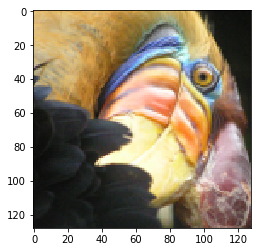

In [74]:
# Part 4: K-Means CLustering on Pixels
K = 16
max_iters = 10
datafile = 'data/bird_small.png'

A = mpimg.imread(datafile)
print("A shape is ",A.shape)
dummy = plt.imshow(A)
# A = A / 255
m, n, _ = A.shape
A = A.reshape(m*n, 3)

In [77]:
def kMeansInitCentroids(X, k):
    m, n = X.shape
    idx = np.random.randint(0, m, k)
    return X[idx, :]
init_centroids = kMeansInitCentroids(A, K)
centroids, idx =run_kmeans(A, init_centroids, 10, False)

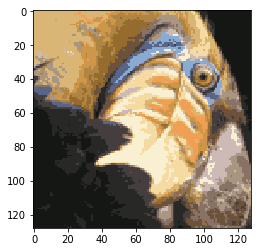

In [86]:
# Part 5: Image Compression
# 假设已经将图片压缩到centroids 和 idx 然后将其解压缩
picture_recover = np.apply_along_axis(lambda i:centroids[i], 0, idx)
picture_recover = picture_recover.reshape(m,n,3)
plt.imshow(picture_recover)

## PCA

Text(0.5, 1.0, 'Example Dataset 1')

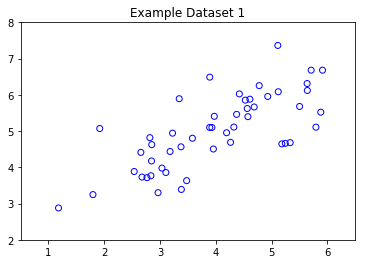

In [127]:
# Part 1: Load Example Dataset
data1 = sio.loadmat('data/ex7data1.mat')
X1 = data1['X']
plt.scatter(X1[:, 0], X1[:, 1], c='', edgecolors='b', marker='o')
plt.axis([0.5, 6.5, 2, 8])
plt.title('Example Dataset 1')

In [192]:
# Part 2: Principal Component Analysis
# 归一化
def featureNormalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=1)
    X_normal = (X-mu)/sigma
    return X_normal, mu, sigma
X1norm, mu1, sigma1 = featureNormalize(X1)

In [196]:
U, S, _ = np.linalg.svd(X1norm.T.dot(X1norm)/X1norm.shape[0])

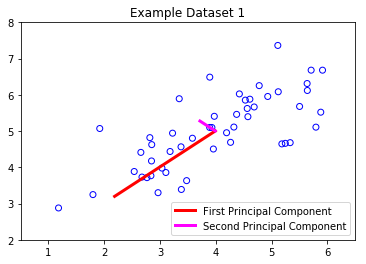

In [197]:
# 画出从均值点出发的两个特征向量(即矩阵U中的两个列向量)
plt.scatter(X1[:, 0], X1[:, 1], c='', edgecolors='b', marker='o')
plt.axis([0.5, 6.5, 2, 8])
plt.title('Example Dataset 1')
plt.plot([mu1[0], mu1[0] + 1.5*S[0]*U[0,0]], 
         [mu1[1], mu1[1] + 1.5*S[0]*U[0,1]],
        color='red',linewidth=3,
        label='First Principal Component')
plt.plot([mu1[0], mu1[0] + 1.5*S[1]*U[1,0]], 
         [mu1[1], mu1[1] + 1.5*S[1]*U[1,1]],
        color='fuchsia',linewidth=3,
        label='Second Principal Component')
leg = plt.legend(loc=4)

In [198]:
# Part 3: Dimension Reduction
def projectData(X, U, k):
    return X.dot(U[:,:k])
K = 1
Z1 = projectData(X1norm, U, K)
print(Z[0])  # 输出1.481274

[1.48127391]


In [199]:
def recoverData(z, U, k):
    return z.dot(U[:,:k].T)
X1_approx = recoverData(Z, U, K)
print(X1_approx[0, :]) # 输出 -1.047419 -1.047419

[-1.04741883 -1.04741883]


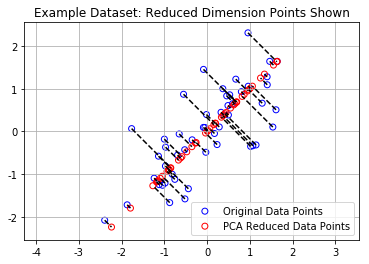

In [200]:
plt.scatter(X1norm[:, 0], X1norm[:, 1], c='', edgecolors='b', marker='o', label='Original Data Points')
plt.scatter(X1_approx[:, 0], X1_approx[:, 1], c='', edgecolors='r', marker='o', label='PCA Reduced Data Points')
for i in range(len(X1norm)):
    temp = np.array([[a,b] for a,b in zip(X1norm[i], X1_approx[i])])
    plt.plot(temp[0, :], temp[1, :], 'k--')
plt.axis('Equal')
plt.grid(True)
plt.title("Example Dataset: Reduced Dimension Points Shown")
plt.legend(loc=4)

In [201]:
# Part 4: Loading and Visualizing Face Data
faces = sio.loadmat('data/ex7faces.mat')
faces = faces['X']

In [202]:
# 以下抄的
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x1032,
    crates an image object from it, and returns it
    """
    width, height = 32, 32
    square = row.reshape(width,height)
    return square.T
    
def displayData(myX, mynrows = 10, myncols = 10):
    """
    Function that picks the first 100 rows from X, creates an image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 32, 32
    nrows, ncols = mynrows, myncols

    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in range(nrows*ncols):
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(myX[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(10,10))
    plt.imshow(big_picture, cmap='gray')

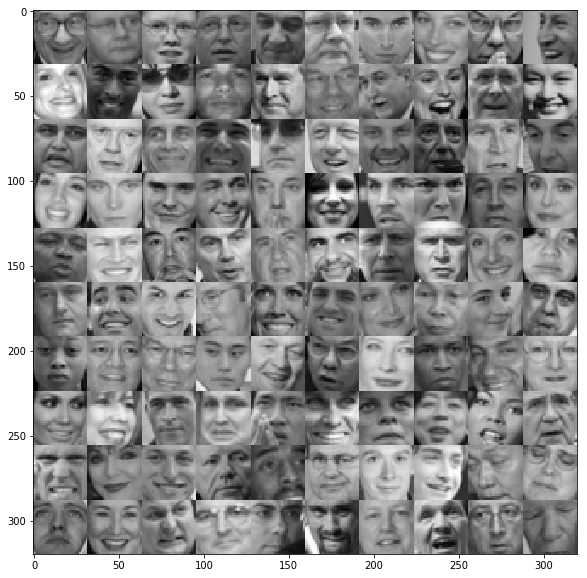

In [203]:
displayData(faces)

In [204]:
# Part 5: PCA on Face Data: Eigenfaces
X_norm, mu, sigma = featureNormalize(faces)
U, S, _ = np.linalg.svd(X_norm.T.dot(X_norm)/X_norm.shape[0])


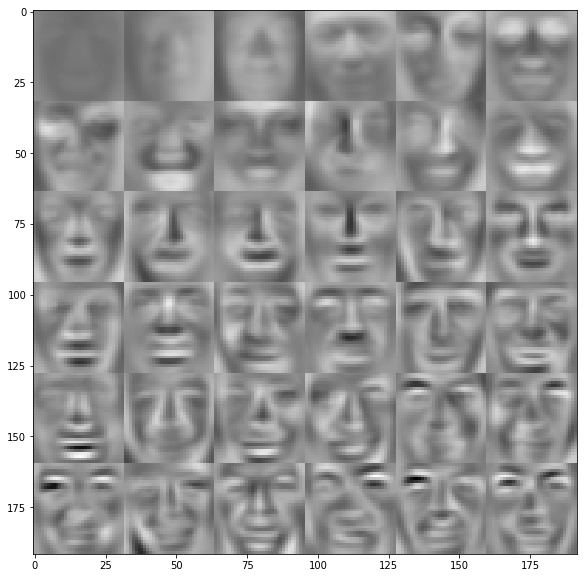

In [205]:

displayData(U[:,:36].T, 6, 6)

In [206]:
# Part 6: Dimension Reduction for Faces
K = 100
Z = projectData(X_norm, U, K)
print(Z.shape)

(5000, 100)


In [207]:
X_approx = recoverData(Z, U, K)

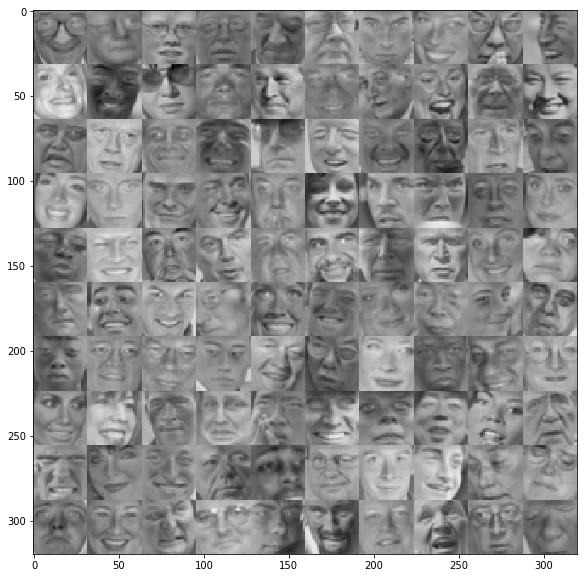

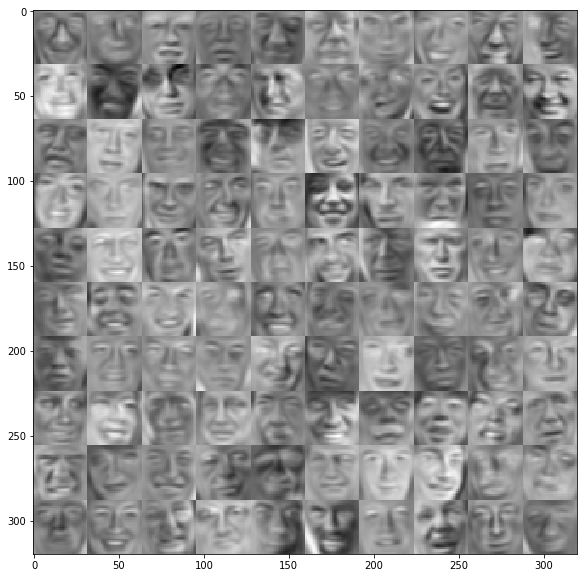

In [208]:
displayData(X_norm[:100, :])
displayData(X_approx[:100, :])